In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import IPython
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
from datetime import datetime, timedelta
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# Uncomment for Interactive Graphs
#%matplotlib widget


name = "GDX"
data = pd.read_csv("data/"+name + ".csv")
data.tail()

2024-10-07 19:52:55.791307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 19:52:55.806858: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 19:52:55.811709: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 19:52:55.824455: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-07 19:52:56.419666: W tensorflow/compiler/tf2

Open   High    Low  Close  Adj Close    Volume      Date
4608  39.80  40.22  39.77  40.09      40.09  27456000  24-09-13
4609  40.00  40.23  39.58  39.89      39.89  12162500  24-09-16
4610  39.70  40.08  39.31  39.49      39.49  17906900  24-09-17
4611  39.76  40.99  39.02  39.06      39.06  41241400  24-09-18
4612  40.10  40.25  39.26  39.72      39.72  22277500  24-09-19

# Load Model

In [2]:
model = tf.keras.models.load_model("models/" + name + ".keras")


model.summary()

I0000 00:00:1728345176.891277  163696 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728345176.933307  163696 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728345176.935466  163696 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728345176.938339  163696 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 20, 128)        │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer (Dense)             │ (None, 9)              │         5,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,845 (214.24 KB)

 Trainable params: 18,281 (71.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 36,564 (142.83 KB)

In [3]:
# Adding indicators
data['Diff_Close'] = data['Adj Close']-data.Open
data['RSI']=ta.rsi(data.Close, length=14)
data['EMAF']=ta.ema(data.Close, length=18)
data['EMAM']=ta.ema(data.Close, length=50)
data['EMAS']=ta.ema(data.Close, length=200)
data.ta.bbands(append=True)
data.ta.stoch(append=True)



data.reset_index(inplace = True)
pd.set_option('display.max_columns', None)

data.tail()

index   Open   High    Low  Close  Adj Close    Volume      Date  \
4608   4608  39.80  40.22  39.77  40.09      40.09  27456000  24-09-13   
4609   4609  40.00  40.23  39.58  39.89      39.89  12162500  24-09-16   
4610   4610  39.70  40.08  39.31  39.49      39.49  17906900  24-09-17   
4611   4611  39.76  40.99  39.02  39.06      39.06  41241400  24-09-18   
4612   4612  40.10  40.25  39.26  39.72      39.72  22277500  24-09-19   

      Diff_Close        RSI       EMAF       EMAM       EMAS  BBL_5_2.0  \
4608        0.29  63.393660  38.020788  37.252686  33.997792  35.563316   
4609       -0.11  61.923518  38.217547  37.356110  34.056421  36.311033   
4610       -0.21  58.977635  38.351489  37.439792  34.110487  37.289938   
4611       -0.70  55.899007  38.426069  37.503330  34.159736  38.764939   
4612       -0.38  59.401965  38.562273  37.590258  34.215062  38.940183   

      BBM_5_2.0  BBU_5_2.0  BBB_5_2.0  BBP_5_2.0  STOCHk_14_3_3  STOCHd_14_3_3  
4608     38.134  40.704684  13.482372   0.880443      72.443237      48.919613  
4609     38.760  41.208967  12.636569   0.730710      91.645955      71.097146  
4610     39.214  41.138062   9.813140   0.571723      89.939111      84.676101  
4611     39.548  40.331061   3.960052   0.188402      77.535372      86.373479  
4612     39.650  40.359817   3.580413   0.549308      71.486727      79.653736

In [4]:
data_set = data.copy()
data_set.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)
data_set.tail()

index   Open   High    Low  Adj Close  Diff_Close        RSI       EMAF  \
4608   4608  39.80  40.22  39.77      40.09        0.29  63.393660  38.020788   
4609   4609  40.00  40.23  39.58      39.89       -0.11  61.923518  38.217547   
4610   4610  39.70  40.08  39.31      39.49       -0.21  58.977635  38.351489   
4611   4611  39.76  40.99  39.02      39.06       -0.70  55.899007  38.426069   
4612   4612  40.10  40.25  39.26      39.72       -0.38  59.401965  38.562273   

           EMAM       EMAS  BBL_5_2.0  BBM_5_2.0  BBU_5_2.0  BBB_5_2.0  \
4608  37.252686  33.997792  35.563316     38.134  40.704684  13.482372   
4609  37.356110  34.056421  36.311033     38.760  41.208967  12.636569   
4610  37.439792  34.110487  37.289938     39.214  41.138062   9.813140   
4611  37.503330  34.159736  38.764939     39.548  40.331061   3.960052   
4612  37.590258  34.215062  38.940183     39.650  40.359817   3.580413   

      BBP_5_2.0  STOCHk_14_3_3  STOCHd_14_3_3  
4608   0.880443      72.443237      48.919613  
4609   0.730710      91.645955      71.097146  
4610   0.571723      89.939111      84.676101  
4611   0.188402      77.535372      86.373479  
4612   0.549308      71.486727      79.653736

In [5]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(-1,1))

df_scaled = sc.fit_transform(data_set.to_numpy())
data_set_scaled_pd = pd.DataFrame(df_scaled, columns=data_set.columns.tolist())



data_set_scaled_pd['index'] = data_set['index']

data_set_scaled_pd.tail()

index      Open      High       Low  Adj Close  Diff_Close       RSI  \
4608   4608  0.004820  0.009989  0.021269   0.195898    0.420548  0.350430   
4609   4609  0.012236  0.010359  0.014179   0.187526    0.365753  0.310595   
4610   4610  0.001112  0.004809  0.004104   0.170783    0.352055  0.230773   
4611   4611  0.003337  0.038476 -0.006716   0.152784    0.284932  0.147354   
4612   4612  0.015944  0.011099  0.002239   0.180410    0.328767  0.242270   

          EMAF      EMAM      EMAS  BBL_5_2.0  BBM_5_2.0  BBU_5_2.0  \
4608 -0.021347 -0.015309 -0.136385  -0.107757  -0.042160  -0.008961   
4609 -0.013510 -0.010960 -0.133631  -0.079099  -0.018426   0.009222   
4610 -0.008174 -0.007441 -0.131091  -0.041580  -0.001213   0.006666   
4611 -0.005204 -0.004769 -0.128777   0.014953   0.011450  -0.022433   
4612  0.000222 -0.001113 -0.126178   0.021670   0.015317  -0.021396   

      BBB_5_2.0  BBP_5_2.0  STOCHk_14_3_3  STOCHd_14_3_3  
4608  -0.525940   0.761191       0.450564      -0.022171  
4609  -0.556316   0.461328       0.839660       0.440119  
4610  -0.657717   0.142935       0.805075       0.723172  
4611  -0.867925  -0.624720       0.553744       0.758553  
4612  -0.881560   0.098046       0.431183       0.618480

In [6]:
X = []
backcandles = 20


data_set_scaled = data_set_scaled_pd.to_numpy()

print("Length of Data", data_set_scaled.shape[0])

features = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

feature_count = len(features)

it = 0
for j in features:
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[it].append(data_set_scaled[i-backcandles:i, j])
    it += 1


X=np.moveaxis(X, [0], [2])

X = np.array(X)
#print(X)
print("X Shape:", X.shape)
print(X[-1][19])

Length of Data 4613
X Shape: (4593, 20, 16)
[ 0.00333704  0.03847577 -0.00671642  0.15278359  0.28493151  0.14735398
 -0.00520376 -0.00476876 -0.12877696  0.01495339  0.0114498  -0.02243267
 -0.86792546 -0.62472028  0.55374401  0.75855333]


In [7]:
y_pred = model.predict(X)
print("Y Predict Shape:", X.shape, len(y_pred)-1)


I0000 00:00:1728345178.233869  163771 service.cc:146] XLA service 0x7a0588004680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728345178.233901  163771 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2024-10-07 19:52:58.246285: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-07 19:52:58.300650: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-07 19:52:59.745797: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 36 bytes spill stores, 36 bytes spill loads

2024-10-07 19:53:00.087891: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function

110/144 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step

I0000 00:00:1728345180.575803  163771 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-10-07 19:53:02.168487: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 84 bytes spill stores, 84 bytes spill loads

2024-10-07 19:53:02.252466: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 396 bytes spill stores, 396 bytes spill loads



144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Y Predict Shape: (4593, 20, 16) 4592


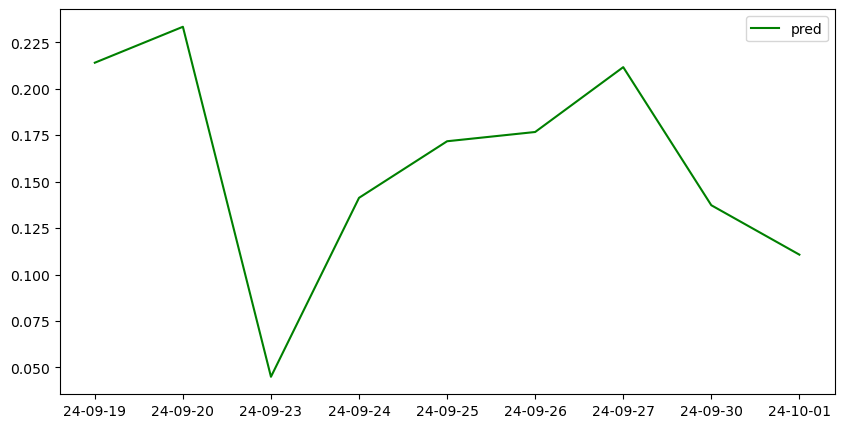

In [8]:
start_date = datetime.strptime(data.Date[len(data.Date)-2], "%y-%m-%d")
next_dates = []

while len(next_dates) < 9:
    start_date += timedelta(days=1)
    
    # Skip Saturdays (5) and Sundays (6)
    if start_date.weekday() < 5:
        next_dates.append(start_date.strftime("%y-%m-%d"))



plt.figure(figsize=(10,5))

plt.plot(next_dates, y_pred[len(y_pred)-1], color='green', label='pred')
plt.legend()
plt.ion()